In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
from itertools import product
import xgboost as xgb

import os
FINAL_PROJECT_DATA = "readonly/final_project_data"
print(os.listdir(FINAL_PROJECT_DATA))

import pandas as pd
items = pd.read_csv(FINAL_PROJECT_DATA + '/items.csv')
shops = pd.read_csv(FINAL_PROJECT_DATA + '/shops.csv')
item_categories = pd.read_csv(FINAL_PROJECT_DATA + '/item_categories.csv')
transactions = pd.read_csv(FINAL_PROJECT_DATA + '/sales_train.csv.gz', compression='gzip')
test = pd.read_csv(FINAL_PROJECT_DATA + '/test.csv.gz', compression='gzip')
#samplesub_df = pd.read_csv(FINAL_PROJECT_DATA + '/sample_submission.csv.gz', compression='gzip')

['test.csv.gz', 'sample_submission.csv.gz', 'shops.csv', 'sales_train.csv.gz', 'item_categories.csv', 'items.csv']


In [2]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name', axis=1)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [3]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

In [4]:
mean_transactions = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
mean_transactions = pd.merge(grid,mean_transactions,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head()


,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


In [5]:
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        mean_df = transactions.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        mean_transactions = pd.merge(mean_transactions, mean_df, on=['date_block_num',type_id], how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,18.0,1.000000,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.0,0.000000,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050000,1.0,1.000000,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.850000,2.0,1.000000,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600000,5.0,1.000000,820.174553,2017.0,1.092041,443.330014,701.0,0.990113
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,2.0,1.000000,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333333,12.0,1.000000,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,16.0,1.142857,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986538,119.0,1.144231,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.200000,5.0,1.000000,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878


In [6]:
lag_variables  = list(mean_transactions.columns[7:])+['item_cnt_day']
lags = [1, 2, 3, 6]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,...,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
mean_transactions = mean_transactions[mean_transactions['date_block_num']>12]
for feat in mean_transactions.columns:
    if 'item_cnt' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(0)
    elif 'item_price' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(mean_transactions[feat].median())

In [8]:
for feat in mean_transactions.columns:
    if 'item_cnt' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(0)
    elif 'item_price' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(mean_transactions[feat].median())

In [9]:
cols_to_drop = lag_variables[:-1] + ['item_price', 'item_name']
training = mean_transactions.drop(cols_to_drop,axis=1)

In [10]:
xgbtrain = xgb.DMatrix(training.iloc[:, training.columns != 'item_cnt_day'].values, training.iloc[:, training.columns == 'item_cnt_day'].values)

In [11]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'} # random parameters
bst = xgb.train(param, xgbtrain)

[12:09:20] WARNING: /Users/igunawan/Workspace/xgboost/src/gbm/gbtree.cc:80: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


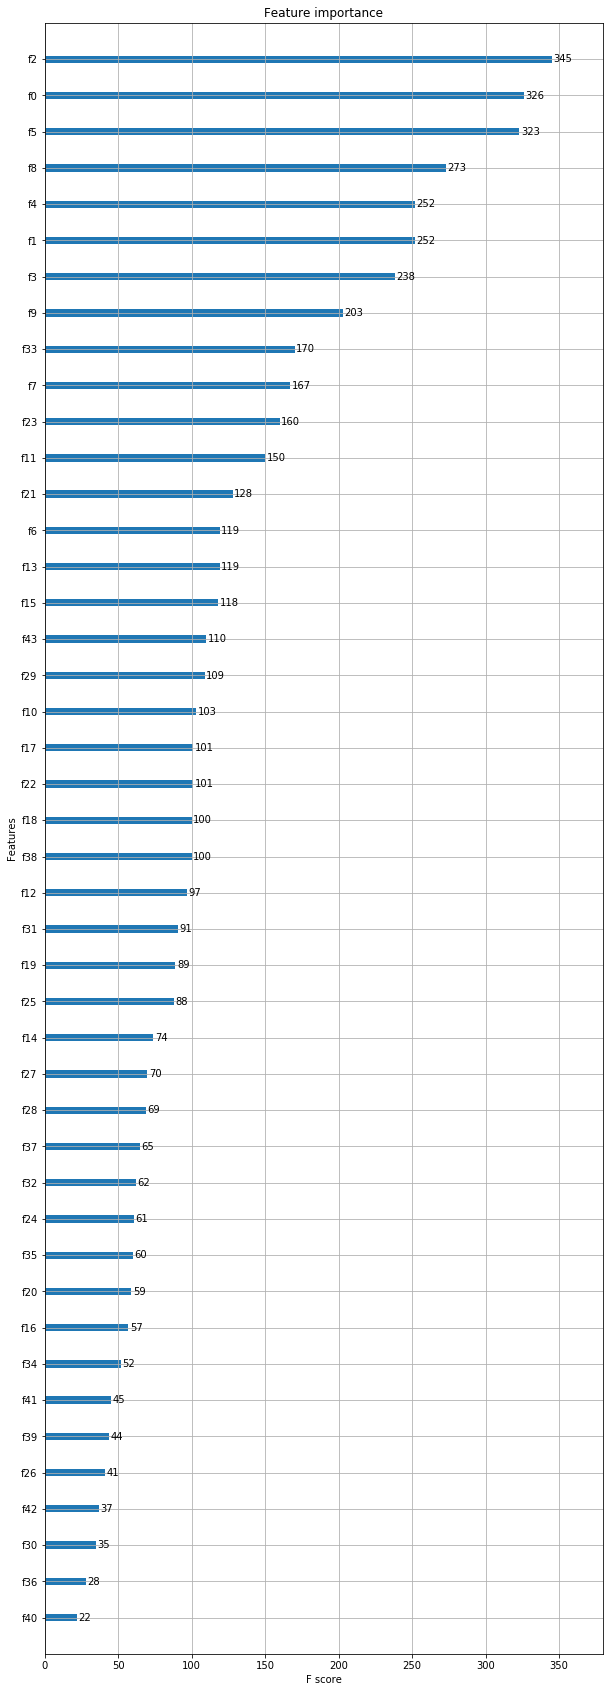

In [12]:
x=xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30) 
cols = list(training.columns)
del cols[cols.index('item_cnt_day')]

In [13]:
test['date_block_num'] = 34
test = pd.merge(test, items, on='item_id', how='left')
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [14]:
test = test.drop(['ID', 'item_name'], axis=1)
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat]=test[feat].fillna(test[feat].median())

xgbpredict = xgb.DMatrix(test.values)
pred = bst.predict(xgbpredict)
pd.Series(pred).describe()

count    214200.000000
mean          0.323660
std           2.885479
min          -1.375026
25%           0.053303
50%           0.126877
75%           0.269293
max         693.166992
dtype: float64

In [15]:
pred = pred.clip(0, 20)
pred.sum()
pd.Series(pred).describe()

count    214200.000000
mean          0.300116
std           0.795518
min           0.000000
25%           0.053303
50%           0.126877
75%           0.269293
max          20.000000
dtype: float64

In [16]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred })
sub_df.to_csv('submission.csv',index=False)